# Demonstrating p-value metric for peak extraction

In [1]:
from leopard_em.pydantic_models.results import MatchTemplateResult

from leopard_em.analysis import (
    extract_peaks_and_statistics_p_value,
    extract_peaks_and_statistics_zscore,
)
from leopard_em.analysis.match_template_peaks import match_template_peaks_to_dataframe

In [9]:
# Using pre-existing data from a previous match_template run
result_dir = "/data/papers/2025_Leopard-EM/xe30kv/results_match_tm_60S"
result_prefix = "xenon_260_000_0_output"
num_orientations = 1_600_000
num_defocus = 13

# Create the MathTemplateResult object
# This would normally be done automaticlly by the MatchTemplateManager after
# the program, but using this for demonstration purposes.
mt_result = MatchTemplateResult(
    allow_file_overwrite=True,
    mip_path=f"{result_dir}/{result_prefix}_mip.mrc",
    scaled_mip_path=f"{result_dir}/{result_prefix}_scaled_mip.mrc",
    correlation_average_path=f"{result_dir}/{result_prefix}_correlation_average.mrc",
    correlation_variance_path=f"{result_dir}/{result_prefix}_correlation_variance.mrc",
    orientation_psi_path=f"{result_dir}/{result_prefix}_orientation_psi.mrc",
    orientation_theta_path=f"{result_dir}/{result_prefix}_orientation_theta.mrc",
    orientation_phi_path=f"{result_dir}/{result_prefix}_orientation_phi.mrc",
    relative_defocus_path=f"{result_dir}/{result_prefix}_relative_defocus.mrc",
    total_projections=num_orientations * num_defocus,
    total_orientations=num_orientations,
    total_defocus=num_defocus,
)

# ensuring that files themselves are not overwritten
mt_result.allow_file_overwrite = False

In [10]:
mt_result.load_tensors_from_paths()

In [11]:
peaks_zscore = extract_peaks_and_statistics_zscore(
    mip=mt_result.mip,
    scaled_mip=mt_result.scaled_mip,
    best_psi=mt_result.orientation_psi,
    best_theta=mt_result.orientation_theta,
    best_phi=mt_result.orientation_phi,
    best_defocus=mt_result.relative_defocus,
    correlation_average=mt_result.correlation_average,
    correlation_variance=mt_result.correlation_variance,
    total_correlation_positions=mt_result.total_projections,
)

df_zscore = match_template_peaks_to_dataframe(peaks_zscore)
df_zscore

peak_values.shape torch.Size([363])
peaks.shape torch.Size([363, 2])


,pos_y,pos_x,mip,scaled_mip,psi,theta,phi,relative_defocus,correlation_mean,correlation_variance,total_correlations
0,564,667,11.697362,11.701625,330.0,52.5,300.000000,400.0,0.014280,0.998415,20800000
1,1210,1165,11.166518,11.089799,145.5,85.0,78.041962,800.0,0.100491,0.997856,20800000
2,373,1803,10.597324,10.555586,276.0,127.5,69.473686,-600.0,0.020027,1.002057,20800000
3,611,1311,10.859697,10.548518,79.5,127.5,221.052628,200.0,0.294458,1.001585,20800000
4,412,1371,10.504148,10.314163,18.0,52.5,268.421051,600.0,0.055017,1.013086,20800000
...,...,...,...,...,...,...,...,...,...,...,...
62,42,949,8.069239,7.929724,112.5,50.0,356.727264,-400.0,0.159580,0.997470,20800000
63,410,432,8.126183,7.886660,78.0,92.5,42.500000,600.0,0.231257,1.001048,20800000
64,274,528,8.144855,7.835763,273.0,5.0,304.615387,-400.0,0.163709,1.018554,20800000
65,286,172,7.942513,7.830094,136.5,57.5,229.090912,1200.0,0.122893,0.998662,20800000


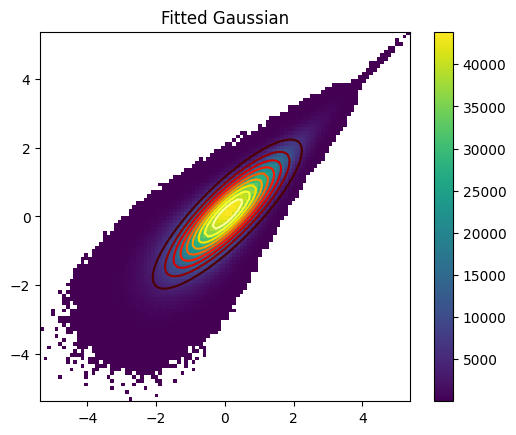

points.shape (12852225, 2)
p_values.shape (3585, 3585)
locs (array([   1,   13,   33,   48,   51,   51,   56,   58,   64,   64,   83,
        108,  108,  111,  126,  138,  152,  154,  173,  178,  179,  183,
        189,  195,  209,  211,  276,  308,  374,  375,  391,  398,  413,
        417,  423,  431,  431,  431,  435,  442,  449,  450,  450,  462,
        464,  467,  475,  507,  529,  533,  537,  556,  558,  558,  560,
        563,  566,  578,  583,  583,  591,  594,  599,  620,  649,  658,
        667,  677,  677,  698,  710,  755,  756,  773,  779,  785,  808,
        809,  809,  818,  824,  830,  832,  835,  835,  836,  836,  839,
        841,  849,  886,  900,  901,  908,  913,  926,  928,  934,  937,
        938,  940,  942,  948,  954,  959,  971,  994, 1018, 1020, 1025,
       1026, 1027, 1029, 1031, 1045, 1061, 1061, 1064, 1064, 1075, 1080,
       1097, 1098, 1128, 1128, 1129, 1130, 1144, 1144, 1163, 1170, 1182,
       1206, 1210, 1229, 1233, 1251, 1252, 1255, 1257, 1258, 12

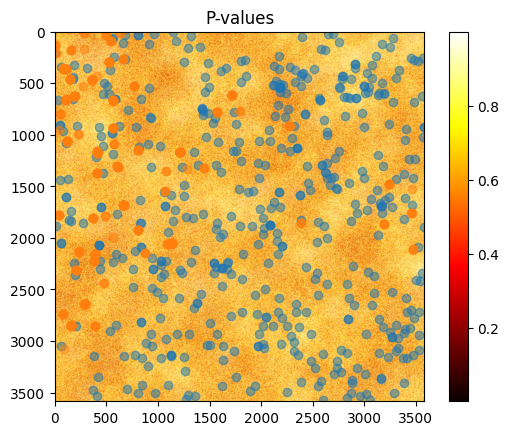

p_values.shape torch.Size([1])
peaks.shape torch.Size([1, 2])


,pos_y,pos_x,mip,scaled_mip,psi,theta,phi,relative_defocus,correlation_mean,correlation_variance,total_correlations
0,2423,801,5.626189,5.450323,15.0,50.0,176.72728,-1000.0,0.042003,1.02456,20800000


In [12]:
peaks_p_value = extract_peaks_and_statistics_p_value(
# peaks_p_value = extract_peaks_and_statistics_zscore(
    mip=mt_result.mip,
    scaled_mip=mt_result.scaled_mip,
    best_psi=mt_result.orientation_psi,
    best_theta=mt_result.orientation_theta,
    best_phi=mt_result.orientation_phi,
    best_defocus=mt_result.relative_defocus,
    correlation_average=mt_result.correlation_average,
    correlation_variance=mt_result.correlation_variance,
    total_correlation_positions=mt_result.total_projections,
    p_value_cutoff=0.001,
)
df_p_value = match_template_peaks_to_dataframe(peaks_p_value)
df_p_value

In [6]:
import matplotlib.pyplot as plt

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([4.8254714 , 4.85598707, 4.88650322, 4.91701889, 4.94753504,
        4.97805071, 5.00856686, 5.03908253, 5.0695982 , 5.10011435,
        5.13063002, 5.16114616, 5.19166183, 5.22217798, 5.25269365,
        5.2832098 , 5.31372547, 5.34424114, 5.37475729, 5.40527296,
        5.43578911, 5.46630478, 5.49682093, 5.5273366 , 5.55785275,
        5.58836842, 5.61888409, 5.64940023, 5.6799159 , 5.71043205,
        5.74094772, 5.77146339, 5.80197954]),
 <BarContainer object of 32 artists>)

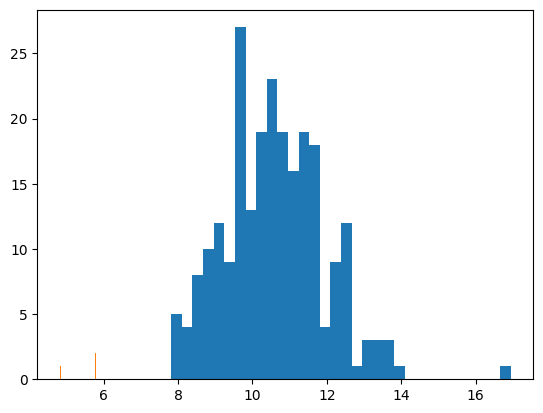

In [7]:
plt.hist(df_zscore["mip"].values, bins=32)
plt.hist(df_p_value["mip"].values, bins=32)

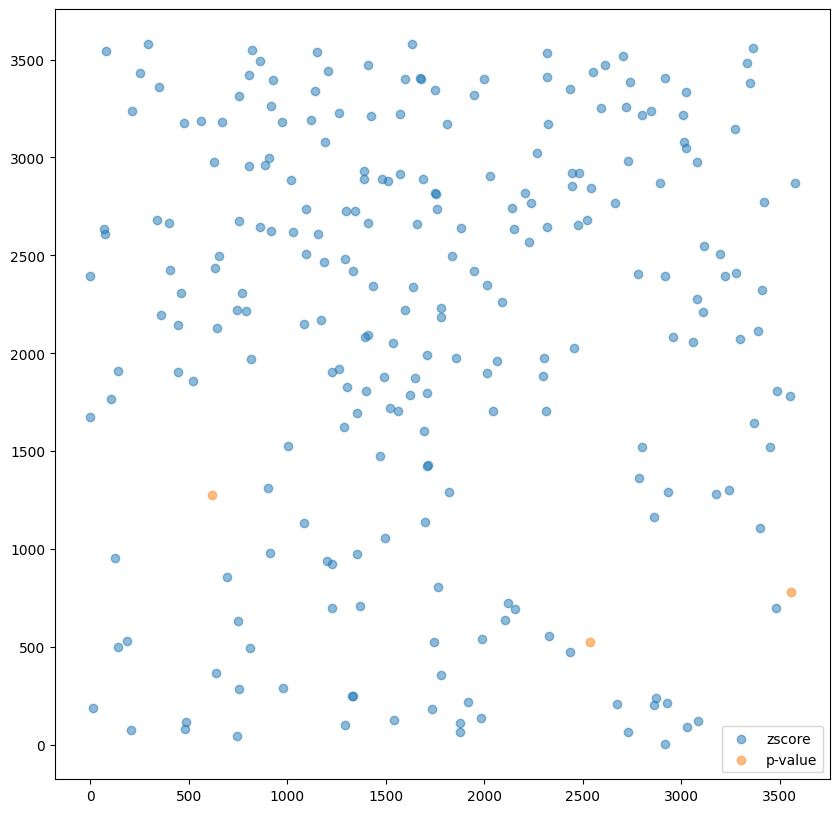

In [8]:
plt.figure(figsize=(10, 10))

# Scatterplot of the positions of the two methods
plt.scatter(df_zscore["pos_y"].values, df_zscore["pos_x"].values, label="zscore", alpha=0.5)
plt.scatter(df_p_value["pos_y"].values, df_p_value["pos_x"].values, label="p-value", alpha=0.5)

plt.legend()
plt.show()